# Titanic Survival Classification

# 1. Defining the Question

## a) Specifying the question

Use the Titanic dataset to correctly classify whether passengers survived or not based on a number of given features.

## b) Defining the metric of success



The kNN model will be considered successful if it has an accuracy of 90% and above.

## c) Understanding the context

The data is of real passengers who were on the Titanic and either survived the tragedy or not.

## d) Recording the Experimental Design

For this project, I'll be doing the following:
1. Data cleaning
2. Exploratory Data Analysis with focus on univariate and bivariate analysis
3. kNN model

## e) Data relevance

The data provided is of relevance to the question. It has a wide range of variables that will be useful in classifying whether a passenger survived or not.

# 2. Reading the Data

In [ ]:
# Importing all the necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Load the dataset

ship = pd.read_csv('/content/train (5).csv')
ship.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 3. Checking the Data

In [ ]:
# Determine the no of records in the dataset

ship.shape

(891, 12)

In [ ]:
# Check datatypes of the columns

ship.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [ ]:
# Check the unique values in each column

ship.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [ ]:
ship.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [ ]:
ship.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [ ]:
ship.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [ ]:
ship.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [ ]:
ship.Cabin.value_counts()

G6             4
B96 B98        4
C23 C25 C27    4
D              3
F2             3
              ..
C99            1
E34            1
C118           1
C54            1
B19            1
Name: Cabin, Length: 147, dtype: int64

In [ ]:
ship.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

# 4. External Data Source Validation

# 5. Tidying the Dataset

In [ ]:
# Drop unnecessary columns
# I'll drop the PassengerId column, Name column and the Ticket column as they'll not be useful in making this classification model

ship.drop(['PassengerId', 'Name', 'Ticket'], axis = 1, inplace = True) 

In [ ]:
# Check for missing values

ship.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [ ]:
# Since Cabin column has a lot of missing values, I'll drop the whole column entirely.

ship.drop(['Cabin'], axis = 1, inplace = True)

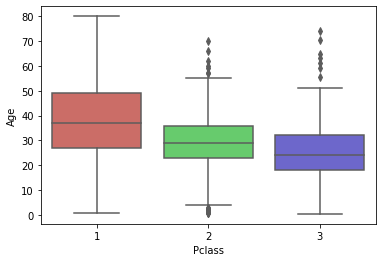

In [ ]:
# For the Age column, I'll not drop it since it has a lot of missing values.

# Let's look at how passenger age is related to their class as a passenger on the boat.
# 
sns.boxplot(x='Pclass', y='Age', data=ship, palette='hls')

# From the boxplots, younger passengers are more likely to be in 3rd class while older ones are more likely to be in 1st class.

In [ ]:
# Write a function that approximates a passenger's age based on their class
# Average age of 1st class passengers is about 37, 2nd class passengers is 29, and 3rd class pasengers is 24.
# Write a function that finds each null value in the Age variable, and for each null, checks the value of the Pclass
# and assigns an age value according to the average age of passengers in that class.

def age_approx(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age

In [ ]:
# When we apply the function and check again for null values, we see that there are no more null values in the age variable.
#
ship['Age'] = ship[['Age', 'Pclass']].apply(age_approx, axis=1)
ship.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

In [ ]:
# Embarked column has only 2 null values, so I'll drop them

ship.dropna(inplace=True)
ship.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [ ]:
# Check for duplicated values

ship.duplicated().any()

True

In [ ]:
# Drop the duplicated columns

ship.drop_duplicates(keep = False, inplace = True)

In [ ]:
# Check whether changes have been made

ship.duplicated().any()

False

In [ ]:
# Check for outliers

# Find IQR Score first

Q1 = ship.quantile(0.25)
Q3 = ship.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Survived     1.0000
Pclass       2.0000
Age         16.0000
SibSp        1.0000
Parch        1.0000
Fare        28.3875
dtype: float64


In [ ]:
ship.shape

(714, 8)

In [ ]:
# Multiply the (IQR) by 1.5
# Add 1.5 x (IQR) to the third quartile. Any number greater than this is a suspected outlier.
# Subtract 1.5 x (IQR) from the first quartile. Any number less than this is a suspected outlier.

(ship < (Q1 - 1.5 * IQR)) |(ship > (Q3 + 1.5 * IQR))


# True indicates the prescence of an outlier

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived
0,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
885,False,False,False,True,False,False,False,False
887,False,False,False,False,False,False,False,False
888,False,False,False,False,False,False,False,False
889,False,False,False,False,False,False,False,False


In [ ]:
# Remove the outliers

ship_outliers = ship[~((ship < (Q1 - 1.5 * IQR)) |(ship > (Q3 + 1.5 * IQR))).any(axis=1)]
ship_outliers.shape

(571, 8)

In [ ]:
# Export the cleaned dataset

ship_outliers.to_csv('ship_clean.csv')

In [ ]:
ship_clean = pd.read_csv('ship_clean.csv')
ship_clean.head()

,Unnamed: 0,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,0,3,male,22.0,1,0,7.2500,S
1,1,1,1,female,38.0,1,0,71.2833,C
2,2,1,3,female,26.0,0,0,7.9250,S
3,3,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,24.0,0,0,8.4583,Q


# 6. Exploratory Data Analysis

## a) Univariate Analysis

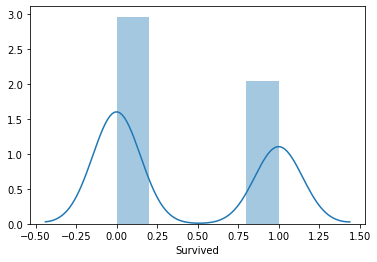

In [ ]:
sns.distplot(ship_clean["Survived"])

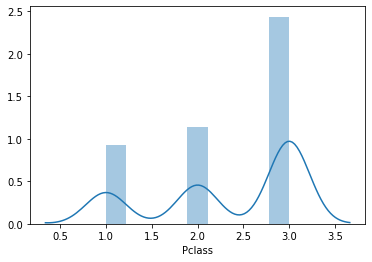

In [ ]:
sns.distplot(ship_clean["Pclass"])

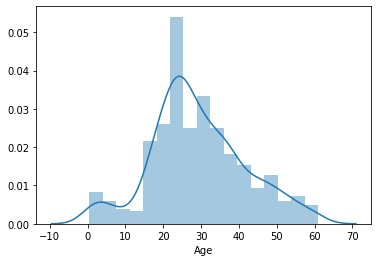

In [ ]:
sns.distplot(ship_clean["Age"])

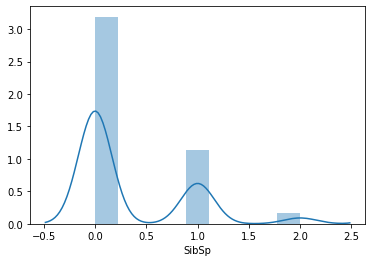

In [ ]:
sns.distplot(ship_clean["SibSp"])

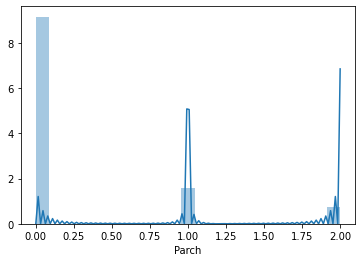

In [ ]:
sns.distplot(ship_clean["Parch"])

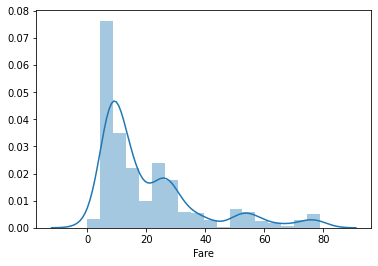

In [ ]:
sns.distplot(ship_clean["Fare"])

**Observation**

1. Most of the passengers in the Titanic did not survive
2. Most of the passengers were in 3rd class
3. The mean age of the passengers is around 25.
4. Most of the passengers did not have any siblings, spouses, parents or children aboard.
5. The average fare paid by the passengers is around 5 pounds.


## b) Bivariate Analysis

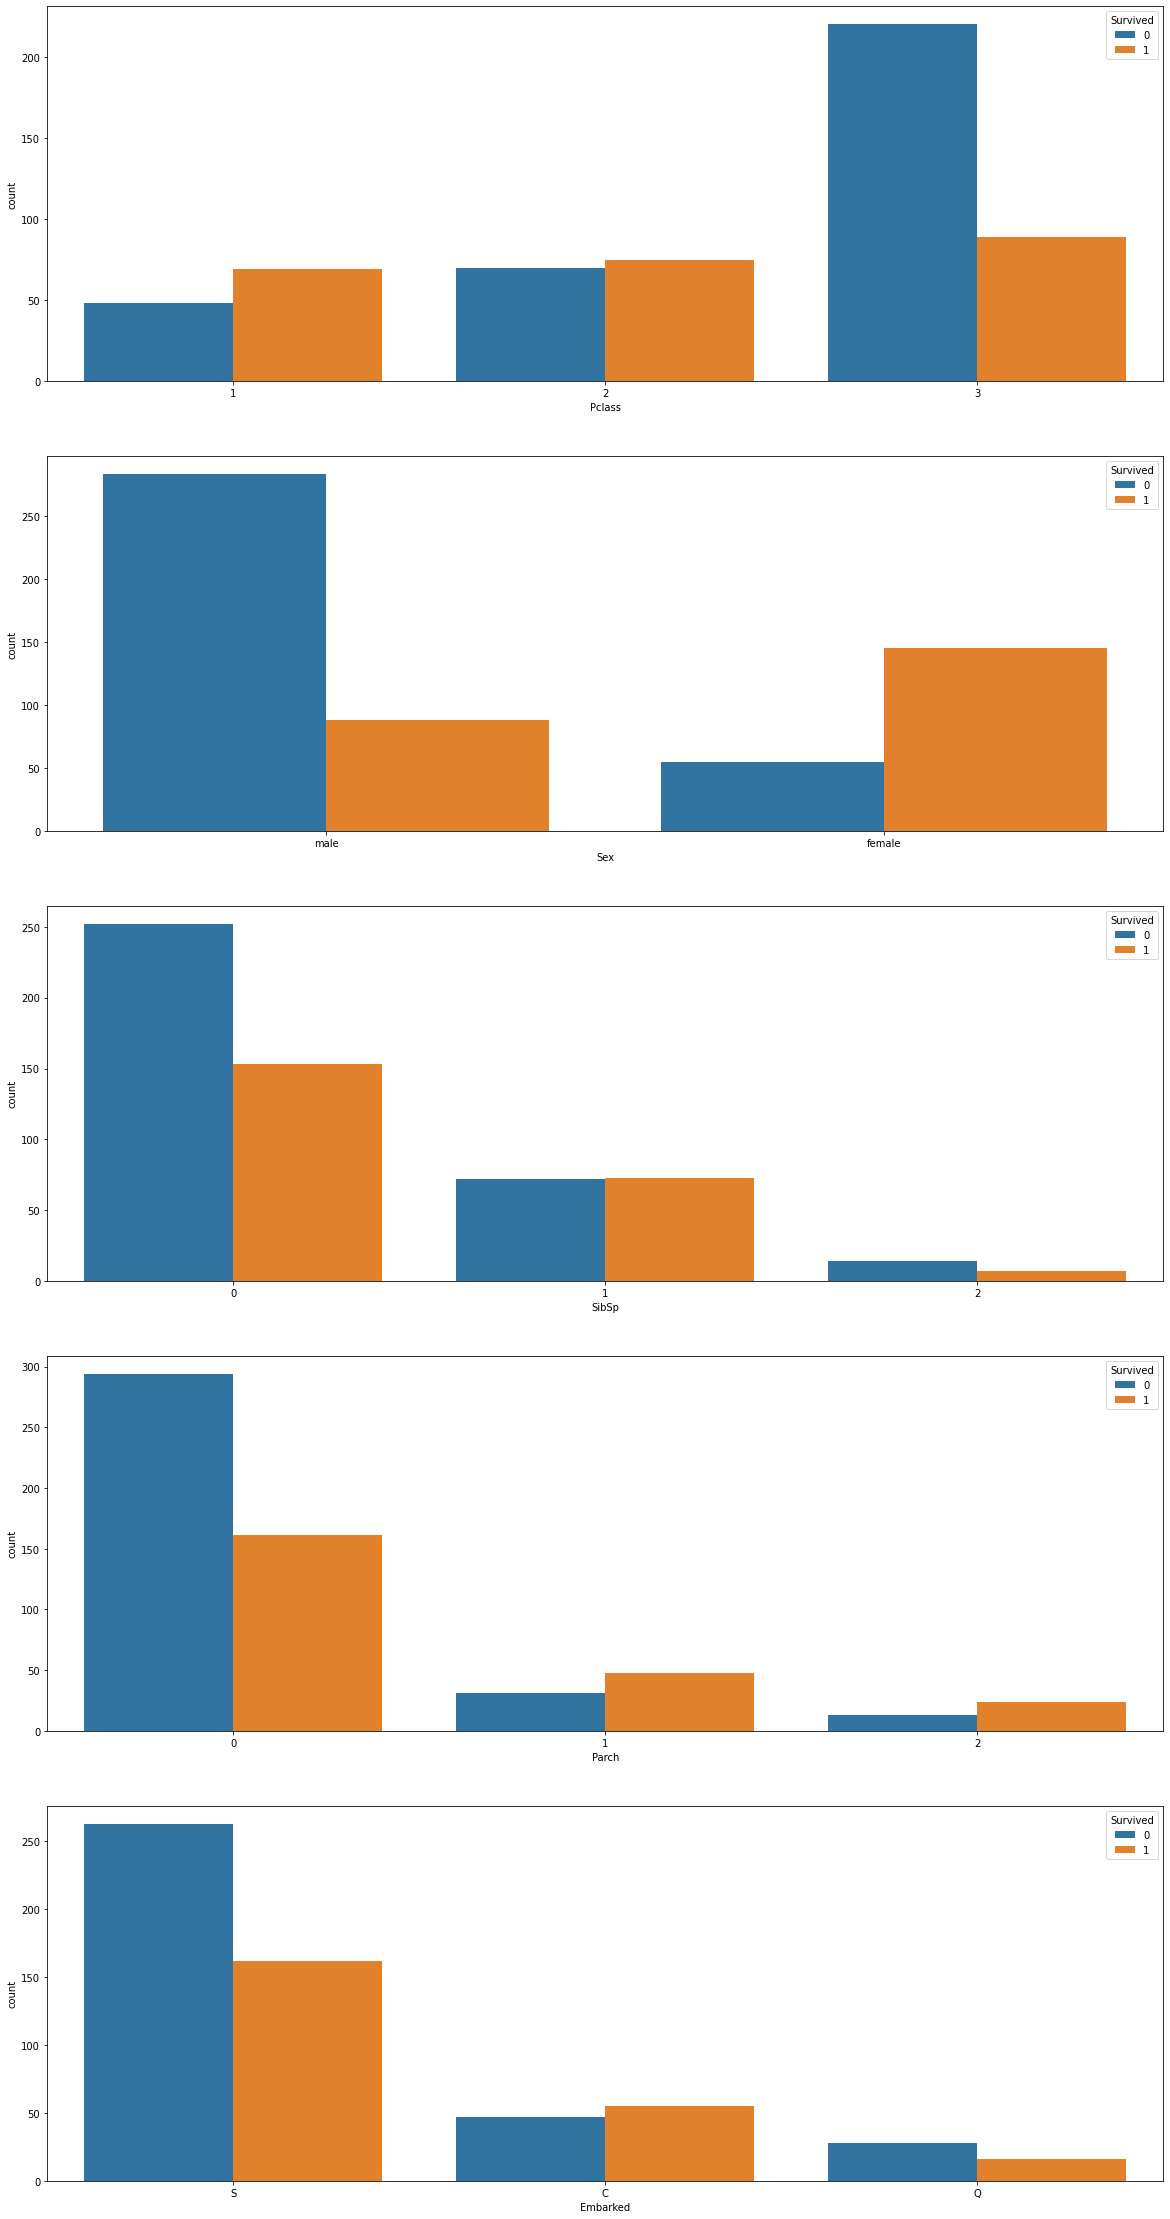

In [ ]:
# Create double bar graphs

f, axes = plt.subplots(5, 1, figsize=[20, 40])

sns.countplot('Pclass', hue= 'Survived', data=ship_clean, ax=axes[0])
sns.countplot('Sex', hue= 'Survived', data=ship_clean, ax=axes[1])
sns.countplot('SibSp', hue= 'Survived', data=ship_clean, ax=axes[2])
sns.countplot('Parch', hue= 'Survived', data=ship_clean, ax=axes[3])
sns.countplot('Embarked', hue= 'Survived', data=ship_clean, ax=axes[4])

**Observation**
1. A bigger proportion of people in 1st class survived than in any of the other 2 classes.
2. More females than males survived.

In [ ]:
# Change categorical data to numerical data so I can create a correlation matrix.

le = LabelEncoder()
ship_clean['Sex'] = le.fit_transform(ship_clean['Sex'])
ship_clean['Embarked'] = le.fit_transform(ship_clean['Embarked'])
ship_clean

,Unnamed: 0,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,0,3,1,22.0,1,0,7.2500,2
1,1,1,1,0,38.0,1,0,71.2833,0
2,2,1,3,0,26.0,0,0,7.9250,2
3,3,1,1,0,35.0,1,0,53.1000,2
4,5,0,3,1,24.0,0,0,8.4583,1
...,...,...,...,...,...,...,...,...,...
566,883,0,2,1,28.0,0,0,10.5000,2
567,887,1,1,0,19.0,0,0,30.0000,2
568,888,0,3,0,24.0,1,2,23.4500,2
569,889,1,1,1,26.0,0,0,30.0000,0


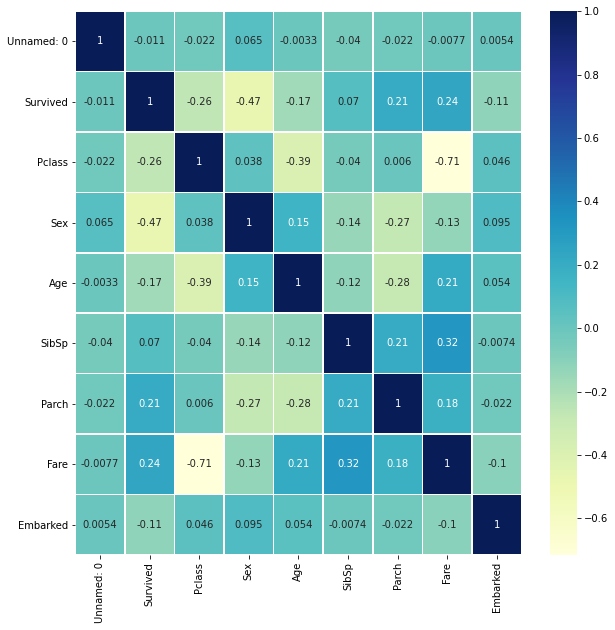

In [ ]:
# Create a correlation matrix
correlation = ship_clean.corr()
correlation


fig, ax = plt.subplots(figsize=(10, 10)) 
sns.heatmap(correlation, annot=True,  linewidths=.5, ax=ax, cmap="YlGnBu")

**Observation**
1. Pclass and Fare are negatively strongly correlated meaning that as one decreases, the other increases.

# 7. K-Nearest Neighbors

## Multicollinearity check

In [ ]:
# Focus here is on the independent variables only
independent_variables = ship_clean.drop(columns=['Unnamed: 0', 'Survived'])

# Let's display the correlations between the variables
a = independent_variables.corr()
a

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
Pclass,1.000000,0.038069,-0.391099,-0.040120,0.005991,-0.714633,0.046464
Sex,0.038069,1.000000,0.150118,-0.138850,-0.272786,-0.126339,0.095193
Age,-0.391099,0.150118,1.000000,-0.116281,-0.282041,0.210738,0.053948
SibSp,-0.040120,-0.138850,-0.116281,1.000000,0.208854,0.323002,-0.007411
Parch,0.005991,-0.272786,-0.282041,0.208854,1.000000,0.176579,-0.021924
Fare,-0.714633,-0.126339,0.210738,0.323002,0.176579,1.000000,-0.103399
Embarked,0.046464,0.095193,0.053948,-0.007411,-0.021924,-0.103399,1.000000


In [ ]:
# Find the inverse of the correlation matrix

pd.DataFrame(np.linalg.inv(a.values), index = a.index, columns=a.columns)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
Pclass,2.484120,-0.033529,0.510612,-0.409244,-0.115035,1.820327,0.042888
Sex,-0.033529,1.110504,-0.112778,0.066645,0.243752,0.066714,-0.085334
Age,0.510612,-0.112778,1.329474,0.100084,0.323291,-0.027172,-0.079692
SibSp,-0.409244,0.066645,0.100084,1.248410,-0.089805,-0.698475,-0.057667
Parch,-0.115035,0.243752,0.323291,-0.089805,1.231348,-0.312230,-0.041253
Fare,1.820327,0.066714,-0.027172,-0.698475,-0.312230,2.613208,0.168717
Embarked,0.042888,-0.085334,-0.079692,-0.057667,-0.041253,0.168717,1.026543


There is no variable that has a VIF score above 4, thus there is no multicollinearity.

## Model 1: 80 - 20 set

In [ ]:
# Divide the data into features and labels

X = ship_clean.iloc[:, 2:]
y = ship_clean.iloc[:, 1]


In [ ]:
# Divide the data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
# Scale the features so they are uniform

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Initialize the KNeighborsClassifier

classifier = KNeighborsClassifier()

# Fit the classifier onto the training data set. This is the base model without any hyperparameter tuning.

classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
# Make predictions on the test data

y_pred = classifier.predict(X_test)

In [ ]:
# Evaluate the performance of the model

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7217391304347827
[[48 11]
 [21 35]]
              precision    recall  f1-score   support

           0       0.70      0.81      0.75        59
           1       0.76      0.62      0.69        56

    accuracy                           0.72       115
   macro avg       0.73      0.72      0.72       115
weighted avg       0.73      0.72      0.72       115



The proportion of correct classifications is at 72%. 

The results from the confusion matrix show that 48 and 35 are the number of correct predictions.
11 and 21 are the number of incorrect predictions.

The precision for class 0 is lower than that of class 1 while it is the opposite for the recall. This shows the model classifies more things under class 1 and there is thus need for optimizing.


## Model 2: 70 - 30 set

In [ ]:
# Divide the data into features and labels

X = ship_clean.iloc[:, 2:]
y = ship_clean.iloc[:, 1]

In [ ]:
# Divide the data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [ ]:
# Scale the features so they are uniform

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Initialize the KNeighborsClassifier

classifier = KNeighborsClassifier()

# Fit the classifier onto the training data set. This is the base model without any hyperparameter tuning.

classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
# Make predictions on the test data

y_pred = classifier.predict(X_test)

In [ ]:
# Evaluate the performance of the model
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7209302325581395
[[74 17]
 [31 50]]
              precision    recall  f1-score   support

           0       0.70      0.81      0.76        91
           1       0.75      0.62      0.68        81

    accuracy                           0.72       172
   macro avg       0.73      0.72      0.72       172
weighted avg       0.72      0.72      0.72       172



The proportion of correct classifications is at 72%. 

The results from the confusion matrix show that 74 and 50 are the number of correct predictions.
17 and 31 are the number of incorrect predictions.

The precision for class 0 is lower than that of class 1 while it is the opposite for the recall. There is no much difference between this model and the first.

The model classifies more things under class 1 and there is thus need for optimizing.

## Model 3: 60 - 40 set

In [ ]:
# Divide the data into features and labels

X = ship_clean.iloc[:, 2:]
y = ship_clean.iloc[:, 1]

In [ ]:
# Divide the data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 0)

In [ ]:
# Scale the features so they are uniform

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Initialize the KNeighborsClassifier

classifier = KNeighborsClassifier()

# Fit the classifier onto the training data set. This is the base model without any hyperparameter tuning.

classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
# Make predictions on the test data

y_pred = classifier.predict(X_test)

In [ ]:
# Evaluate the performance of the model

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7292576419213974
[[104  24]
 [ 38  63]]
              precision    recall  f1-score   support

           0       0.73      0.81      0.77       128
           1       0.72      0.62      0.67       101

    accuracy                           0.73       229
   macro avg       0.73      0.72      0.72       229
weighted avg       0.73      0.73      0.73       229



The proportion of correct classifications is slightly higher for this model at 73%.

The results from the confusion matrix show that 104 and 63 are the number of correct predictions.
24 and 38 are the number of incorrect predictions.

Though the precision for class 0 is lower than that of class 1, it has significantly improved compared to the other models. This shows the model got considerably better at classifying though there is still need for optimization.

## Optimized Model

In [ ]:
# Divide the data into features and labels

X = ship_clean.iloc[:, 2:]
y = ship_clean.iloc[:, 1]

In [ ]:
# Divide the data into training and test sets
# I'll use the test size at 0.3 as I want a good enough size for the test set. 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [ ]:
# Scale the features so they are uniform

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# I'll do hyperparameter tuning using GridSearchCV

# List Hyperparameters that we want to tune

leaf_size = list(range(1,20))
n_neighbors = list(range(1,20))
p=[1,2]

# Convert them to a dictionary

hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

# Instantiate the KNeighborsClassifier

clf = KNeighborsClassifier()

# Use GridSearch

grid = GridSearchCV(clf, hyperparameters, cv=10)

In [ ]:
# Fit the model

best_model = grid.fit(X_train,y_train)

In [ ]:
# Print The value of best Hyperparameters

print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Best leaf_size: 2
Best p: 2
Best n_neighbors: 17


In [ ]:
# Make predictions on the test data

grid_pred = grid.predict(X_test)

In [ ]:
# Evaluate the performance of the model

print("Accuracy:",metrics.accuracy_score(y_test, grid_pred))
print(confusion_matrix(y_test, grid_pred))
print(classification_report(y_test, grid_pred))

Accuracy: 0.7383720930232558
[[80 11]
 [34 47]]
              precision    recall  f1-score   support

           0       0.70      0.88      0.78        91
           1       0.81      0.58      0.68        81

    accuracy                           0.74       172
   macro avg       0.76      0.73      0.73       172
weighted avg       0.75      0.74      0.73       172



The accuracy of the optimized model has improved. It's at 74%.

The results from the confusion matrix show that 80 and 47 are the number of correct predictions.
11 and 34 are the number of incorrect predictions.

The precision for class 0 is the same as that of the first 2 base models that had not been optimized. The 3rd model out-performs this one in precision.

The f1-score (showing percentage of positive predictions that were correct) for this model however is better than that of the first 3 base models.

# 8. Implementing the Solution

The model that works best for this question is the optimized KNeighboursClassifier though it still does not give the desired accuracy of over 90%.

# 9. Challenging the Solution

1. The accuracy of the kNN model depends on the quality of the data. I noticed upon removing outliers, some columns lost info that I perceived as important. This could have contributed to the accuracy of the model being quite low. 

*  In future, I will find a way to retain the info I think is important so it won't be removed as part of the outliers.



2. The range used for the hyperparameters dictionary when tuning could be widened to see if the accuracy will increase.


# 10. Follow up Questions

**1. Did we have the right data**

The data provided for this question was relevant and yielded good results

**2. Do we need other data to answer our questions**

No. The data provided was sufficient

**3. Do we have the right question**

The question was right for the data given